<a href="https://colab.research.google.com/github/zzaranghaeminiya/Final-Team6/blob/main/6%ED%8C%80_%ED%8C%8C%EC%9D%B4%EB%84%90_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**전처리**

In [ ]:
# ========================================
# 1. 라이브러리 불러오기
# ========================================
import pandas as pd
from google.colab import files

# ========================================
# 2. 데이터 불러오기
# ========================================
# 업로드한 파일 불러오기 (경로는 필요에 따라 변경)
df = pd.read_csv("/content/combined_dataset.csv")

# ========================================
# 3. 전처리
# ========================================

# (1) review 시리즈 + host_is_superhost 결측치 제거
review_cols = [col for col in df.columns if "review" in col.lower()]
df = df.dropna(subset=review_cols + ["host_is_superhost"], how="any")
df = df.dropna(subset=["price"],how="any")

# (2) response / acceptance 결측치는 -1로 대체
for col in df.columns:
    if "response" in col.lower() or "acceptance" in col.lower():
        df[col] = df[col].fillna(-1)

# (3) has_availability 생성/갱신
avail_cols = ["availability_30", "availability_60", "availability_90", "availability_365"]
df["has_availability"] = df[avail_cols].apply(lambda row: "t" if (row >= 0).any() else "f", axis=1)

# ========================================
# 4. CSV 저장
# ========================================
output_path = "/content/processed_dataset.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print("✅ 전처리 및 저장 완료:", output_path)

# ========================================
# 5. 로컬 다운로드 (선택)
# ========================================
files.download(output_path)

In [ ]:
import pandas as pd
from google.colab import files

# ========================================
# 2. 데이터 불러오기
# ========================================
# 업로드한 파일 불러오기 (경로는 필요에 따라 변경)
df = pd.read_csv("/content/processed_dataset.csv")
missing_summary_df = pd.DataFrame({
    "missing_count": df.isnull().sum(),
    "missing_ratio(%)": (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values(by="missing_count", ascending=False)
missing_summary_df.head(20)

In [ ]:
import pandas as pd
from google.colab import files

# ========================================
# 1. 데이터 불러오기
# ========================================
df = pd.read_csv("/content/processed_dataset.csv")

# ========================================
# 2. 결측치 2개 이상인 열 제거
# ========================================
col_na_count = df.isnull().sum()
df_cleaned = df.loc[:, col_na_count < 2].copy()

print("✅ 원본 데이터 shape:", df.shape)
print("✅ 결측치 2개 이상 열 제거 후 shape:", df_cleaned.shape)

# ========================================
# 3. CSV 저장
# ========================================
output_path = "/content/processed_dataset_cleaned_columns.csv"
df_cleaned.to_csv(output_path, index=False, encoding="utf-8-sig")

print("저장 완료:", output_path)

# ========================================
# 4. 로컬 다운로드
# ========================================
files.download(output_path)


In [ ]:
# =========================================
# Trust Index 생성 풀 파이프라인
# =========================================
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from google.colab import files


path = "/content/processed_dataset_cleaned_columns.csv"
df = pd.read_csv(path)


rate_cols = ["host_response_rate", "host_acceptance_rate"]

# -1을 NaN으로
for c in rate_cols:
    if c in df.columns:
        df[c] = df[c].replace(-1, np.nan)

# '%' 제거 후 숫자로
for c in rate_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.replace("%", "", regex=False)
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 중앙값으로 채우기
for c in rate_cols:
    if c in df.columns:
        med = df[c].median()
        df[c] = df[c].fillna(med)

# -----------------------------------------
# 3) 스케일링 대상 4개 컬럼 지정
# -----------------------------------------
cols = ["review_scores_rating", "number_of_reviews", "host_response_rate", "host_acceptance_rate"]
missing_cols = [c for c in cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"데이터에 다음 컬럼이 없습니다: {missing_cols}")

# 숫자형 변환
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 남은 NaN이 있다면 0으로
df[cols] = df[cols].fillna(0)

# -----------------------------------------
# 4) Min-Max 스케일링 (0~1)
# -----------------------------------------
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df[cols]), columns=[f"{c}__scaled" for c in cols], index=df.index)
df = pd.concat([df, scaled], axis=1)

# -----------------------------------------
# 5) 가중치 적용하여 Trust Index 계산
#    review_scores_rating - 0.40
#    number_of_reviews    - 0.30
#    host_response_rate   - 0.15
#    host_acceptance_rate - 0.15
# -----------------------------------------
weights = {
    "review_scores_rating": 0.40,
    "number_of_reviews": 0.30,
    "host_response_rate": 0.15,
    "host_acceptance_rate": 0.15,
}

df["trust_index"] = (
    weights["review_scores_rating"] * df["review_scores_rating__scaled"] +
    weights["number_of_reviews"]    * df["number_of_reviews__scaled"] +
    weights["host_response_rate"]   * df["host_response_rate__scaled"] +
    weights["host_acceptance_rate"] * df["host_acceptance_rate__scaled"]
).round(6)


out_path = "/content/processed_with_trust_index.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("💾 Saved:", out_path)
files.download(out_path)


print("\n[Preview]")
display(df[[
    "review_scores_rating","number_of_reviews",
    "host_response_rate","host_acceptance_rate",
    "review_scores_rating__scaled","number_of_reviews__scaled",
    "host_response_rate__scaled","host_acceptance_rate__scaled",
    "trust_index"
]].head(10))

**가설**/**시각화**

In [ ]:
import scipy.stats as stats
import numpy as np

# 슈퍼호스트 여부를 0/1로 변환
df["host_is_superhost"] = df["host_is_superhost"].map({"t":1, "f":0})

# 그룹 분리
super_trust = df[df["host_is_superhost"] == 1]["trust_index"]
non_super_trust = df[df["host_is_superhost"] == 0]["trust_index"]

# 1) 독립표본 t-검정
t_stat, p_val = stats.ttest_ind(super_trust, non_super_trust, equal_var=False)
print("T-test: t=%.3f, p=%.5f" % (t_stat, p_val))

# 2) Mann-Whitney U 검정 (비모수)
u_stat, p_val_u = stats.mannwhitneyu(super_trust, non_super_trust, alternative="two-sided")
print("Mann-Whitney U: U=%.3f, p=%.5f" % (u_stat, p_val_u))

# 3) 효과크기 (Cohen's d)
mean_diff = super_trust.mean() - non_super_trust.mean()
pooled_std = np.sqrt(((super_trust.std()**2) + (non_super_trust.std()**2)) / 2)
cohens_d = mean_diff / pooled_std
print("Cohen's d:", cohens_d)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그룹 컬럼 준비
df["host_is_superhost"] = df["host_is_superhost"].map({1:"Superhost", 0:"Non-superhost"})

plt.figure(figsize=(10,6))

# 1) 박스플롯
sns.boxplot(data=df, x="host_is_superhost", y="trust_index", palette="Set2")
sns.stripplot(data=df, x="host_is_superhost", y="trust_index",
              color="black", alpha=0.3, jitter=0.2, size=2)
plt.title("Trust Index by Superhost Status (Boxplot + Stripplot)")
plt.show()

# 2) 바이올린플롯
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="host_is_superhost", y="trust_index", palette="Set2", inner="quartile")
plt.title("Trust Index by Superhost Status (Violin Plot)")
plt.show()

# 3) 평균 + 신뢰구간
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="host_is_superhost", y="trust_index", ci=95, palette="Set2")
plt.title("Mean Trust Index with 95% CI")
plt.show()

In [ ]:
# ===============================================
# per-scrape_id 반복 검정 (호스트 단위 평균 기준)
# - 각 scrape_id마다:
#     1) host_id로 묶어 number_of_reviews 평균(mean)
#     2) 슈퍼호스트 vs 일반호스트 비교 (one-sided: 슈퍼 > 일반)
#     3) Welch t-test, Mann-Whitney U, 효과크기 계산
# - 결과를 테이블로 저장 및 요약 출력
# ===============================================
import pandas as pd
import numpy as np
from scipy import stats

# ---------- 0. 설정 ----------
CSV_PATH = "/content/combined_dataset.csv"
MIN_GROUP_N = 5      # 각 그룹(슈퍼/일반) 최소 표본 수
ALPHA = 0.05
OUT_CSV = "/content/scrape_id_level_tests_mean.csv"

# ---------- 1. 데이터 로드 / 정리 ----------
df = pd.read_csv(CSV_PATH)
df["host_is_superhost"] = df["host_is_superhost"].map({"t":1,"f":0})
df["number_of_reviews"] = pd.to_numeric(df["number_of_reviews"], errors="coerce")

# ---------- 2. 검정 함수 ----------
def one_snapshot_test(snapshot_df: pd.DataFrame):
    """
    scrape_id별 데이터에서 host_id 단위로 리뷰 '평균'을 집계하고,
    슈퍼호스트 vs 일반호스트 단측 검정을 수행.
    """
    # 호스트 단위 집계 (평균 기준)
    hosts = snapshot_df.groupby("host_id").agg(
        number_of_reviews_mean=("number_of_reviews","mean"),
        host_is_superhost=("host_is_superhost","first")
    ).reset_index()

    sh = hosts.loc[hosts["host_is_superhost"]==1, "number_of_reviews_mean"].dropna()
    nsh = hosts.loc[hosts["host_is_superhost"]==0, "number_of_reviews_mean"].dropna()

    n1, n2 = len(sh), len(nsh)
    if n1 < MIN_GROUP_N or n2 < MIN_GROUP_N:
        return {"n_super": n1, "n_non": n2, "mean_super": sh.mean() if n1>0 else np.nan,
                "mean_non": nsh.mean() if n2>0 else np.nan,
                "t_stat": np.nan, "p_t_one": np.nan,
                "u_stat": np.nan, "p_u_one": np.nan,
                "cohens_d": np.nan, "hedges_g": np.nan, "rank_biserial": np.nan,
                "note": f"SKIP (<{MIN_GROUP_N} per group)"}

    # Welch t-test (단측)
    t_stat, p_two = stats.ttest_ind(sh, nsh, equal_var=False)
    p_t_one = p_two/2 if t_stat > 0 else 1 - p_two/2

    # Mann-Whitney U (단측)
    u_stat, p_u_one = stats.mannwhitneyu(sh, nsh, alternative="greater")

    # 효과 크기
    s1, s2 = np.var(sh, ddof=1), np.var(nsh, ddof=1)
    sp = np.sqrt(((n1-1)*s1+(n2-1)*s2)/(n1+n2-2)) if (n1+n2-2)>0 else np.nan
    d = (np.mean(sh)-np.mean(nsh))/sp if sp and sp>0 else np.nan
    J = 1 - (3/(4*(n1+n2)-9)) if (n1+n2)>2 else 1.0
    g = d*J if np.isfinite(d) else np.nan
    r_rb = 1 - (2*u_stat)/(n1*n2) if (n1>0 and n2>0) else np.nan

    return {"n_super": n1, "n_non": n2,
            "mean_super": float(np.mean(sh)), "mean_non": float(np.mean(nsh)),
            "t_stat": float(t_stat), "p_t_one": float(p_t_one),
            "u_stat": float(u_stat), "p_u_one": float(p_u_one),
            "cohens_d": float(d) if np.isfinite(d) else np.nan,
            "hedges_g": float(g) if np.isfinite(g) else np.nan,
            "rank_biserial": float(r_rb) if np.isfinite(r_rb) else np.nan,
            "note": ""}

# ---------- 3. 모든 scrape_id 반복 ----------
results = []
for sid, snap in df.groupby("scrape_id", sort=True):
    res = one_snapshot_test(snap)
    res["scrape_id"] = sid
    results.append(res)

res_df = pd.DataFrame(results)
res_df["sig_t_one"] = res_df["p_t_one"] < ALPHA
res_df["sig_u_one"] = res_df["p_u_one"] < ALPHA

# ---------- 4. 요약 출력 ----------
print("✅ 총 스냅샷 수:", res_df.shape[0])
print("• t-test(단측) 유의 스냅샷:", int(res_df["sig_t_one"].sum()))
print("• U-test(단측) 유의 스냅샷:", int(res_df["sig_u_one"].sum()))

print("\n📊 슈퍼-일반 평균차 큰 상위 10개:")
res_df["mean_diff"] = res_df["mean_super"] - res_df["mean_non"]
display(res_df.sort_values("mean_diff", ascending=False).head(10))

print("\n📉 p값 작은 상위 10개 (t-test 단측):")
display(res_df.sort_values("p_t_one", ascending=True).head(10))

print("\n📉 p값 작은 상위 10개 (MWU 단측):")
display(res_df.sort_values("p_u_one", ascending=True).head(10))

# ---------- 5. 저장 ----------
res_df = res_df[["scrape_id","n_super","n_non","mean_super","mean_non","mean_diff",
                 "t_stat","p_t_one","u_stat","p_u_one","cohens_d","hedges_g","rank_biserial",
                 "sig_t_one","sig_u_one","note"]]
res_df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"\n💾 결과 저장 완료: {OUT_CSV}")

In [ ]:
# 응답 시간 그룹별 리뷰 퀄리티 ANOVA 분산분석


import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from scipy import stats

# 데이터 로드
df = pd.read_csv("/content/combined_dataset.csv")

# 숫자 변환
df["review_scores_rating"] = pd.to_numeric(df["review_scores_rating"], errors="coerce")
df["number_of_reviews"] = pd.to_numeric(df["number_of_reviews"], errors="coerce")

# 결측 제거
df = df.dropna(subset=["review_scores_rating","number_of_reviews","host_response_time"]).copy()

# 리뷰 퀄리티 지표 생성
df["review_quality"] = df["review_scores_rating"] * np.log1p(df["number_of_reviews"])

# 그룹 나누기 (응답 시간 카테고리 그대로)
groups = [g["review_quality"].values for _, g in df.groupby("host_response_time")]

# ANOVA 수행
f_stat, p_val = f_oneway(*groups)
print("=== ANOVA 결과 ===")
print(f"F = {f_stat:.3f}, p = {p_val:.6f}")

# 그룹별 요약 통계
summary = df.groupby("host_response_time")["review_quality"].agg(["count","mean","std"])
print("\n=== 그룹별 통계 요약 ===")
print(summary)


# Tukey HSD 사후검정
tukey = pairwise_tukeyhsd(df["review_quality"], df["host_response_time"], alpha=0.05)
print(tukey)


# 그룹별 통계 계산
group_stats = df.groupby("host_response_time")["review_quality"].agg(["mean","count","std"])
group_stats["sem"] = group_stats["std"] / np.sqrt(group_stats["count"])  # 표준오차
group_stats["ci95"] = 1.96 * group_stats["sem"]  # 95% 신뢰구간

# 순서 정렬 (빠른 응답 → 느린 응답)
order = ["within an hour", "within a few hours", "within a day", "a few days or more"]
group_stats = group_stats.loc[order]

# 그래프
plt.figure(figsize=(9,6))
bars = plt.bar(group_stats.index, group_stats["mean"],
               yerr=group_stats["ci95"], capsize=6,
               color=["#FF5A5F","#FFB6C1","#87CEEB","#90EE90"],
               edgecolor="black", linewidth=1.2)

# 라벨 추가
for bar, mean in zip(bars, group_stats["mean"]):
    plt.text(bar.get_x() + bar.get_width()/2, mean + 0.3,
             f"{mean:.2f}", ha="center", va="bottom", fontsize=10, weight="bold")

plt.ylabel("Average Review Quality")
plt.title("Review Quality by Host Response Time (Mean ± 95% CI)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# 시기별 슈퍼호스트 vs. 비슈퍼호스트 평균 리뷰 수 비율


# scrape_id × host_id 유일하게 유지
df_unique = df.drop_duplicates(subset=["scrape_id","host_id"])

# 그룹별 집계 (합계, 평균, 호스트 수)
agg_result = (
    df_unique.groupby(["scrape_id","host_is_superhost"])["number_of_reviews"]
    .agg(["sum","mean","count"])  # 합계, 평균, 호스트수
    .reset_index()
)

# pivot으로 정리
mean_table = agg_result.pivot(index="scrape_id", columns="host_is_superhost", values="mean") \
                       .rename(columns={"t":"Superhost_mean","f":"Non-super_mean"}) \
                       .fillna(0)

# scrape_id별 전체 평균 리뷰 수
mean_table["Total_mean"] = mean_table["Superhost_mean"] + mean_table["Non-super_mean"]

# 비율 계산
mean_table["Superhost_ratio"] = mean_table["Superhost_mean"] / mean_table["Total_mean"]
mean_table["Non-super_ratio"] = mean_table["Non-super_mean"] / mean_table["Total_mean"]

print(mean_table)


import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10,6))

bars1 = ax.bar(mean_table.index, mean_table["Superhost_ratio"],
               label="Superhost", color="#FF5A5F")
bars2 = ax.bar(mean_table.index, mean_table["Non-super_ratio"],
               bottom=mean_table["Superhost_ratio"],
               label="Non-superhost", color="#FFB6C1")

# 라벨 달기
def add_labels(bars, values, bottom=0):
    for bar, val, b in zip(bars, values, bottom):
        ax.text(bar.get_x() + bar.get_width()/2, b + val/2,
                f"{val*100:.1f}%", ha="center", va="center",
                fontsize=10, weight="bold")

add_labels(bars1, mean_table["Superhost_ratio"], bottom=[0]*len(mean_table))
add_labels(bars2, mean_table["Non-super_ratio"], bottom=mean_table["Superhost_ratio"].values)

ax.set_ylabel("Proportion of average reviews per host (%)")
ax.set_title("Share of average reviews per host by Superhost status")
ax.set_ylim(0,1.05)

# 범례를 그래프 밖으로
ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.08), ncol=2, frameon=False)

plt.grid(False)
plt.tight_layout()
plt.show()



**머신러닝(클러스터링)**

[INFO] hosts aggregated: 3151 | host_id: host_id

=== Learned proportions (Weighted EM + box + target-prox + rank-constraints; no post-hoc cutting) ===
  tier  weight_learned  count  ratio_data
Rookie          0.2152    658      0.2088
Rising          0.4103   1459      0.4630
 Super          0.3156    969      0.3075
Master          0.0588     65      0.0206

Component means (ascending): [0.3838, 0.414, 0.9259, 1.955]
Cut points (PC1): [-24.7471, -0.3792, 1.8961]

=== Tier-wise means (selected features) ===
          number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
tier_gmm                                                                     
Rookie                 3.18                   1.87                    0.40   
Rising                 3.65                   2.43                    0.63   
Super                  4.31                   3.46                    1.41   
Master                 6.30                   5.19                    2.71   

          host_re

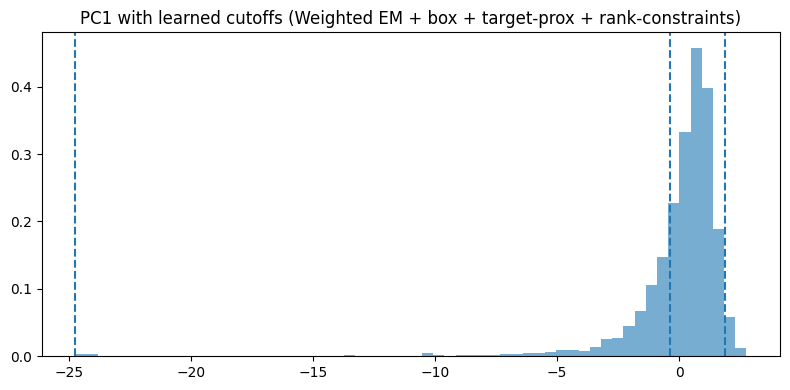


[SAVE] /content/gmm_constrained_host_tiers.csv


In [ ]:
IN_PATH  = "/content/processed_with_trust_index.csv"
OUT_PATH = "/content/gmm_constrained_host_tiers.csv"
RANDOM_SEED = 42

import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
np.random.seed(RANDOM_SEED)

# ===================== TUNING (aim ≈ 25/40/25/10) & Super↑ / Master↓ =====================
K = 4

# 중앙 집중(꼬리 영향 억제)
WEIGHT_CENTER_Q = 0.50
WEIGHT_SIGMA    = 0.14

# 사전(Dirichlet) — Super 우호, Master 억제
USE_DIRICHLET_PRIOR = True
PRIOR_VEC       = np.array([0.22, 0.42, 0.28, 0.08])
PRIOR_STRENGTH  = 60.0

# 혼합비 박스 제약
USE_PI_BOX = True
PI_FLOOR = np.array([0.20, 0.38, 0.30, 0.04])
PI_CEIL  = np.array([0.28, 0.52, 0.40, 0.08])

# 타깃 혼합비로 proximal pull
PI_TARGET = np.array([0.25, 0.40, 0.25, 0.10]).reshape(-1,1)
ETA_MIX   = 0.45

# 랭크 제약 파라미터 (Super/ Master 평균·분산 제약)
Q_SUPER_LO, Q_SUPER_HI = 0.70, 0.90
Q_MASTER_LO = 0.98
MASTER_VAR_CAP_FACTOR = 0.10
SUPER_VAR_FLOOR_FACTOR = 0.15

# ===================== utils: robust load & numeric coercion =====================
def robust_read_csv(path: str) -> pd.DataFrame:
    p = Path(path)
    if not p.exists(): raise FileNotFoundError(path)
    for enc in ("utf-8","utf-8-sig","cp949","latin1"):
        for mode in [(None, None), ('sniff', None), (None, 'quote')]:
            try:
                if mode==(None,None):
                    return pd.read_csv(p, engine="python", on_bad_lines="skip", encoding=enc)
                if mode==('sniff', None):
                    return pd.read_csv(p, engine="python", on_bad_lines="skip", encoding=enc, sep=None)
                if mode==(None, 'quote'):
                    return pd.read_csv(p, engine="python", on_bad_lines="skip", encoding=enc, quotechar="'")
            except Exception:
                pass
    raise RuntimeError("CSV load failed with multiple strategies.")

BOOL_TRUE  = re.compile(r'^\s*(1|t|true|y|yes)\s*$', re.I)
BOOL_FALSE = re.compile(r'^\s*(0|f|false|n|no)\s*$', re.I)

def coerce_boolish_series(s: pd.Series) -> pd.Series:
    s_str = s.astype(str)
    out = pd.Series(np.nan, index=s.index, dtype="float64")
    out[s_str.str.match(BOOL_TRUE,  na=False)] = 1.0
    out[s_str.str.match(BOOL_FALSE, na=False)] = 0.0
    return out

def coerce_numeric_like_series(s: pd.Series) -> pd.Series:
    if s.dtype != 'object':
        return pd.to_numeric(s, errors='coerce')
    boolish = coerce_boolish_series(s)
    s_clean = (s.astype(str)
                 .str.replace('[,$%]', '', regex=True)
                 .str.replace(r'[^0-9eE\+\-\.]', '', regex=True))
    num = pd.to_numeric(s_clean, errors='coerce')
    out = num.copy()
    m = boolish.notna()
    out[m] = boolish[m]
    if out.notna().mean() < 0.2:
        out[:] = np.nan
    return out

def coerce_numeric_like_df(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype == 'object':
            df2[c] = coerce_numeric_like_series(df2[c])
        else:
            df2[c] = pd.to_numeric(df2[c], errors='coerce')
    return df2

# ===================== host-level aggregation =====================
def detect_host_id(df: pd.DataFrame) -> str | None:
    for c in df.columns:
        if re.search(r'\bhost[_ ]?id\b', str(c).lower()):
            return c
    return None

def choose_agg(col: str) -> str | None:
    cl = col.lower()
    if re.search(r'\b(host[_ ]?id|listing[_ ]?id)\b', cl): return None
    if re.search(r'(number_of_reviews(_\w+)?|_count(_\w+)?|bookings?|nights?)$', cl): return "sum"
    if re.search(r'calculated_host_listings_count', cl): return "max"
    if re.search(r'(review_scores|_score|_rating|response_rate|acceptance_rate|cancellation_rate)', cl): return "mean"
    if re.search(r'(price|adr|fee|cost)', cl): return "mean"
    if re.search(r'availability', cl): return "mean"
    return "median"

def safe_log1p_series(s: pd.Series) -> pd.Series:
    return np.log1p(pd.to_numeric(s, errors="coerce").clip(lower=0))

def safe_logit_from_pct_series(s: pd.Series) -> pd.Series:
    p = (pd.to_numeric(s, errors="coerce") / 100.0).clip(1e-6, 1-1e-6)
    return np.log(p / (1 - p))

# ===================== weighted EM + box + target-prox + rank-constraints + re-seed =====================
def make_weights(pc1, center_q=WEIGHT_CENTER_Q, sigma=WEIGHT_SIGMA):
    r = pd.Series(pc1).rank(method="average", pct=True).values
    w = np.exp(-0.5 * ((r - center_q)/sigma)**2)
    return w / w.mean()

def init_means_by_quantiles_balanced(pc1, K):
    qs = np.quantile(pc1, [0.08, 0.45, 0.70, 0.92])  #
    return qs.reshape(K,1).astype(float)

def project_pi_with_bounds(pi_raw, floor, ceil):
    pi = np.clip(pi_raw, floor, ceil)
    s = pi.sum()
    if 0.999 <= s <= 1.001:
        return pi / s
    free = (pi > floor + 1e-12) & (pi < ceil - 1e-12)
    resid = 1.0 - pi.sum()
    if free.any():
        pi[free] += resid * (pi[free] / max(pi[free].sum(), 1e-12))
        pi = np.clip(pi, floor, ceil)
        pi /= pi.sum()
        return pi
    idx = np.argmax(ceil - pi)
    pi[idx] = min(ceil[idx], pi[idx] + resid)
    pi = np.clip(pi, floor, ceil)
    pi /= pi.sum()
    return pi

def gmm1d_weighted_em_constrained(pc1,
                                  use_prior=USE_DIRICHLET_PRIOR,
                                  prior_vec=PRIOR_VEC,
                                  prior_strength=PRIOR_STRENGTH,
                                  use_pi_box=USE_PI_BOX,
                                  pi_floor=PI_FLOOR,
                                  pi_ceil=PI_CEIL,
                                  max_iter=1200, tol=1e-6, random_state=42):
    rng = np.random.default_rng(random_state)
    x = pc1.reshape(-1,1).astype(float); N = len(pc1)

    # sample weights
    w = make_weights(pc1)

    # init
    mu  = init_means_by_quantiles_balanced(pc1, K)
    var = np.full((K,1), np.var(pc1)/2 + 1e-3)
    pi  = np.full((K,1), 1.0/K)

    # prior
    if use_prior:
        a = np.array(prior_vec, dtype=float); a = a / a.sum()
        alpha = (a * prior_strength).reshape(K,1)
    else:
        alpha = np.ones((K,1))

    # box constraints
    if use_pi_box:
        floor = (np.array(pi_floor, dtype=float).reshape(K,1)) * (0.99 / max(1e-9, np.array(pi_floor).sum()))
        ceil  = (np.array(pi_ceil,  dtype=float).reshape(K,1)) * (1.01 / max(1e-9, np.array(pi_ceil).sum()))
    else:
        floor = ceil = None

    def logN(xx, m, v):
        return -0.5*(np.log(2*np.pi*v.T) + ((xx - m.T)**2)/v.T)

    prev_ll = -np.inf; min_var = 1e-6
    for it in range(max_iter):
        # ---------- E-step ----------
        logp = logN(x, mu, var) + np.log(pi.T)
        mlog = logp.max(axis=1, keepdims=True)
        prob = np.exp(logp - mlog)
        gamma = prob / prob.sum(axis=1, keepdims=True)

        gw = gamma * w.reshape(-1,1)
        Nk = gw.sum(axis=0, keepdims=True).T

        # ---------- M-step: mean/var ----------
        mu  = (gw.T @ x) / Nk
        diff2 = (x - mu.T)**2
        var = ((gw * diff2).sum(axis=0, keepdims=True).T / Nk).clip(min_var)

        # ---------- Re-seed to prevent collapse ----------
        eps = 1e-3
        for k in range(K):
            if Nk[k, 0] < eps:
                q = min(0.97 + 0.007*k, 0.995)  # 좀 더 오른쪽으로 재시드
                mu[k, 0]  = np.quantile(pc1, q)
                var[k, 0] = max(np.var(pc1) * 0.4, 1e-3)
                Nk[k, 0]  = eps

        # ---------- NEW: rank-based constraints (Super↑, Master↓) ----------
        order_tmp = np.argsort(mu.ravel())
        mu_r  = mu[order_tmp].copy()
        var_r = var[order_tmp].copy()

        # Master(3): 최상위 꼬리만 담당하도록 평균/분산 제한
        mu_r[3, 0]  = max(mu_r[3, 0], np.quantile(pc1, Q_MASTER_LO))
        var_cap_master = np.var(pc1) * MASTER_VAR_CAP_FACTOR
        var_r[3, 0] = min(var_r[3, 0], max(var_cap_master, 1e-3))

        # Super(2): 중-우측(70~90%)에 고정, 커버리지 확보 위해 분산 하한 부여
        mu_r[2, 0]  = np.clip(mu_r[2, 0],
                              np.quantile(pc1, Q_SUPER_LO),
                              np.quantile(pc1, Q_SUPER_HI))
        var_floor_super = np.var(pc1) * SUPER_VAR_FLOOR_FACTOR
        var_r[2, 0] = max(var_r[2, 0], var_floor_super)

        # Rookie(0), Rising(1): 과도 확장 방지(약한 상한)
        var_r[0, 0] = min(var_r[0, 0], np.var(pc1) * 0.25)
        var_r[1, 0] = min(var_r[1, 0], np.var(pc1) * 0.30)

        inv = np.argsort(order_tmp)
        mu  = mu_r[inv]
        var = var_r[inv]

        # ---------- mixing weights: prior -> target-prox -> (box) ----------
        pi_raw = (Nk + (alpha - 1.0)) if use_prior else Nk
        pi_raw = pi_raw / pi_raw.sum()

        pi_tgt  = PI_TARGET / PI_TARGET.sum()
        pi_bias = (1.0 - ETA_MIX) * pi_raw + ETA_MIX * pi_tgt
        pi_bias = pi_bias / pi_bias.sum()

        pi = project_pi_with_bounds(pi_bias, floor, ceil) if use_pi_box else pi_bias

        # ---------- convergence (weighted log-like) ----------
        logp = logN(x, mu, var) + np.log(pi.T)
        mlog = logp.max(axis=1, keepdims=True)
        ll = np.sum(w.reshape(-1,1) * (mlog + np.log(np.exp(logp-mlog).sum(axis=1, keepdims=True))))
        if np.abs(ll - prev_ll) < tol * (1 + np.abs(prev_ll)):
            break
        prev_ll = ll

    # order left->right
    order = np.argsort(mu.ravel())
    mu, var, pi = mu[order], var[order], pi[order]

    # posterior/labels
    def post_x(xx, m, v, ppi):
        lg = -0.5*(np.log(2*np.pi*v.T) + ((xx - m.T)**2)/v.T) + np.log(ppi.T)
        mlg = lg.max(axis=1, keepdims=True)
        pp = np.exp(lg - mlg)
        return pp / pp.sum(axis=1, keepdims=True)

    P = post_x(x, mu, var, pi)
    lab = P.argmax(axis=1)

    # cutoffs: posterior crossings
    xs = np.linspace(pc1.min(), pc1.max(), 1500).reshape(-1,1)
    Px = post_x(xs, mu, var, pi)
    cuts = []
    for k in range(K-1):
        idx = int(np.argmin(np.abs(Px[:,k] - Px[:,k+1])))
        cuts.append(float(xs[idx,0]))

    return mu.ravel(), var.ravel(), pi.ravel(), lab, np.array(cuts), w

# ===================== PIPELINE =====================
raw0 = robust_read_csv(IN_PATH)
raw  = coerce_numeric_like_df(raw0)

host_id = detect_host_id(raw0)
if host_id is None:
    raise RuntimeError("host_id column not found.")
numeric_cols = [c for c in raw.columns if pd.api.types.is_numeric_dtype(raw[c])]
agg_map = {}
for c in numeric_cols:
    a = choose_agg(c)
    if a: agg_map[c] = a
df = raw.groupby(host_id).agg(agg_map).reset_index()
print(f"[INFO] hosts aggregated: {len(df)} | host_id: {host_id}")

quality_feats = [c for c in [
    "review_scores_accuracy","review_scores_cleanliness","review_scores_checkin",
    "review_scores_communication","review_scores_location","review_scores_value"
] if c in df.columns]
volume_feats = [c for c in [
    "number_of_reviews","number_of_reviews_ltm","number_of_reviews_l30d","reviews_per_month",
    "bookings","bookings_count","nights","nights_booked"
] if c in df.columns]
ops_feats = [c for c in ["host_response_rate","host_acceptance_rate","cancellation_rate"] if c in df.columns]
use_feats = quality_feats + volume_feats + ops_feats
if not use_feats:
    raise RuntimeError("No usable features after host aggregation.")

for c in ops_feats:
    df[c] = pd.to_numeric(df[c], errors="coerce").replace(-1, np.nan)
for c in volume_feats:
    df[c] = safe_log1p_series(df[c])
if "cancellation_rate" in ops_feats:
    df["cancellation_rate"] = 100 - pd.to_numeric(df["cancellation_rate"], errors="coerce")
for c in ops_feats:
    df[c] = safe_logit_from_pct_series(df[c])

X = df[use_feats].copy()
for c in use_feats:
    med = X[c].median()
    if np.isnan(med): med = 0.0
    X[c] = X[c].fillna(med)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=1, random_state=RANDOM_SEED)
pc1 = pca.fit_transform(X_scaled).ravel()

if ops_feats:
    ops_mean = X[ops_feats].mean(axis=1)
    if pd.Series(pc1).corr(ops_mean, method="spearman") < 0:
        pc1 = -pc1

mu, var, pi, labels, cuts, w_used = gmm1d_weighted_em_constrained(pc1)

tier_names = np.array(["Rookie","Rising","Super","Master"])
tiers = tier_names[labels]

out = df[[host_id]].copy()
out["pc1"] = pc1
out["tier_gmm"] = tiers
out["comp_label"] = labels
out["sample_weight_used"] = w_used

counts = pd.Series(labels).value_counts().reindex(range(K), fill_value=0)
ratios = (counts / counts.sum()).round(4)
report = pd.DataFrame({
    "tier": tier_names,
    "weight_learned": np.round(pi, 4),
    "count": counts.values,
    "ratio_data": ratios.values
})
print("\n=== Learned proportions (Weighted EM + box + target-prox + rank-constraints; no post-hoc cutting) ===")
print(report.to_string(index=False))
print("\nComponent means (ascending):", np.round(mu, 4).tolist())
print("Cut points (PC1):", [round(float(c),4) for c in cuts])

check_cols = [c for c in ["number_of_reviews","number_of_reviews_ltm","number_of_reviews_l30d",
                          "host_response_rate","host_acceptance_rate","cancellation_rate"] if c in df.columns]
if check_cols:
    g = pd.concat([out, df[check_cols]], axis=1).groupby("tier_gmm")[check_cols].mean().reindex(tier_names).round(2)
    print("\n=== Tier-wise means (selected features) ===")
    print(g)

if "trust_index" in raw0.columns:
    ti_host = raw0.groupby(host_id)["trust_index"].mean()
    ti_aligned = ti_host.loc[out[host_id]].values
    rho, pval = spearmanr(out["pc1"].values, ti_aligned, nan_policy="omit")
    print(f"\nSpearman(pc1 vs trust_index@host) = {rho:.3f} (p={pval:.1e})")

try:
    plt.figure(figsize=(8,4))
    plt.hist(pc1, bins=60, density=True, alpha=0.6)
    for c in cuts:
        plt.axvline(c, linestyle="--")
    plt.title("PC1 with learned cutoffs (Weighted EM + box + target-prox + rank-constraints)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Plot skipped:", e)

out.to_csv(OUT_PATH, index=False)
print(f"\n[SAVE] {OUT_PATH}")


**특징**, **시각화**

[INFO] hosts aggregated: 3151 | host_id: host_id

=== Learned proportions (Weighted EM + box + target-prox + rank-constraints; no post-hoc cutting) ===
  tier  weight_learned  count  ratio_data
Rookie           0.215    658       0.209
Rising           0.410   1459       0.463
 Super           0.316    969       0.307
Master           0.059     65       0.021

Component means (ascending): [0.3838, 0.414, 0.9259, 1.955]
Cut points (PC1): [-24.7471, -0.3792, 1.8961]

=== Tier-wise means (selected features) ===
          number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
tier_gmm                                                                     
Rookie                3.180                  1.870                   0.400   
Rising                3.650                  2.430                   0.630   
Super                 4.310                  3.460                   1.410   
Master                6.300                  5.190                   2.710   

          host_re

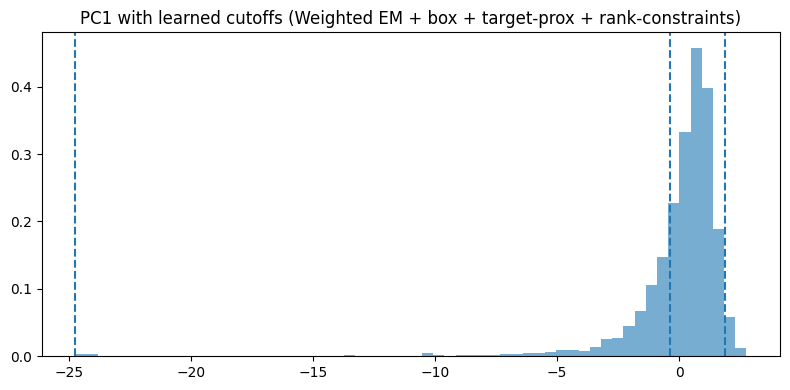


[SAVE] /content/gmm_constrained_host_tiers.csv

=== Tier-wise stats (Review scores + Acceptance rate) ===


review_scores_accuracy                                       \
                          count   min   q25 median   q75   max  mean   
tier_gmm                                                               
Rookie                      658 3.000 4.560  4.710 4.830 5.000 4.679   
Rising                     1459 4.000 4.820  4.900 4.995 5.000 4.882   
Super                       969 1.000 4.837  4.920 4.970 5.000 4.716   
Master                       65 4.795 4.920  4.947 4.972 5.000 4.940   

         review_scores_cleanliness                                       \
                             count   min   q25 median   q75   max  mean   
tier_gmm                                                                  
Rookie                         658 3.170 4.366  4.600 4.800 5.000 4.553   
Rising                        1459 3.770 4.730  4.846 4.960 5.000 4.821   
Super                          969 1.000 4.765  4.897 4.960 5.000 4.670   
Master                          65 4.614 4.877  4.940 4.970 5.000 4.914   

         review_scores_checkin                                       \
                         count   min   q25 median   q75   max  mean   
tier_gmm                                                              
Rookie                     658 3.000 4.640  4.790 4.906 5.000 4.745   
Rising                    1459 4.295 4.840  4.920 5.000 5.000 4.898   
Super                      969 1.000 4.852  4.930 4.973 5.000 4.759   
Master                      65 4.822 4.920  4.952 4.975 4.990 4.945   

         review_scores_communication                                       \
                               count   min   q25 median   q75   max  mean   
tier_gmm                                                                    
Rookie                           658 3.910 4.650  4.793 4.930 5.000 4.753   
Rising                          1459 4.000 4.865  4.938 5.000 5.000 4.913   
Super                            969 1.000 4.885  4.950 4.990 5.000 4.768   
Master                            65 4.862 4.950  4.970 4.985 5.000 4.963   

         review_scores_location                                       \
                          count   min   q25 median   q75   max  mean   
tier_gmm                                                               
Rookie                      658 3.500 4.500  4.700 4.860 5.000 4.663   
Rising                     1459 4.000 4.730  4.850 4.960 5.000 4.826   
Super                       969 1.000 4.780  4.890 4.950 5.000 4.738   
Master                       65 4.762 4.894  4.930 4.970 5.000 4.921   

         review_scores_value                                       \
                       count   min   q25 median   q75   max  mean   
tier_gmm                                                            
Rookie                   658 3.000 4.431  4.570 4.710 5.000 4.558   
Rising                  1459 4.000 4.726  4.810 4.912 5.000 4.813   
Super                    969 1.000 4.760  4.850 4.915 5.000 4.654   
Master                    65 4.733 4.865  4.905 4.925 5.000 4.892   

         host_acceptance_rate                                                
                        count    min     q25  median     q75     max   mean  
tier_gmm                                                                     
Rookie                    585  0.000  60.000  93.878 100.000 100.000 75.522  
Rising                   1317  0.000  86.000  99.000 100.000 100.000 87.828  
Super                     940  0.000  98.000 100.000 100.000 100.000 94.395  
Master                     65 95.000 100.000 100.000 100.000 100.000 99.756


=== Missing rate by tier (host_acceptance_rate) ===
          host_acceptance_rate_missing_rate
tier_gmm                                   
Rookie                                0.111
Rising                                0.097
Super                                 0.030
Master                                0.000


In [ ]:
IN_PATH  = "/content/processed_with_trust_index.csv"
OUT_PATH = "/content/gmm_constrained_host_tiers.csv"
RANDOM_SEED = 42

import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
np.random.seed(RANDOM_SEED)

# ===================== TUNING (aim ≈ 25/40/25/10) & Super↑ / Master↓ =====================
K = 4
WEIGHT_CENTER_Q = 0.50
WEIGHT_SIGMA    = 0.14

USE_DIRICHLET_PRIOR = True
PRIOR_VEC       = np.array([0.22, 0.42, 0.28, 0.08])
PRIOR_STRENGTH  = 60.0

USE_PI_BOX = True
PI_FLOOR = np.array([0.20, 0.38, 0.30, 0.04])
PI_CEIL  = np.array([0.28, 0.52, 0.40, 0.08])

PI_TARGET = np.array([0.25, 0.40, 0.25, 0.10]).reshape(-1,1)
ETA_MIX   = 0.45

Q_SUPER_LO, Q_SUPER_HI = 0.70, 0.90
Q_MASTER_LO = 0.98
MASTER_VAR_CAP_FACTOR = 0.10
SUPER_VAR_FLOOR_FACTOR = 0.15

# ===================== utils (load & coercion) =====================
def robust_read_csv(path: str) -> pd.DataFrame:
    p = Path(path)
    if not p.exists(): raise FileNotFoundError(path)
    for enc in ("utf-8","utf-8-sig","cp949","latin1"):
        for mode in [(None, None), ('sniff', None), (None, 'quote')]:
            try:
                if mode==(None,None):
                    return pd.read_csv(p, engine="python", on_bad_lines="skip", encoding=enc)
                if mode==('sniff', None):
                    return pd.read_csv(p, engine="python", on_bad_lines="skip", encoding=enc, sep=None)
                if mode==(None, 'quote'):
                    return pd.read_csv(p, engine="python", on_bad_lines="skip", encoding=enc, quotechar="'")
            except Exception:
                pass
    raise RuntimeError("CSV load failed.")

BOOL_TRUE  = re.compile(r'^\s*(1|t|true|y|yes)\s*$', re.I)
BOOL_FALSE = re.compile(r'^\s*(0|f|false|n|no)\s*$', re.I)

def coerce_boolish_series(s: pd.Series) -> pd.Series:
    s_str = s.astype(str)
    out = pd.Series(np.nan, index=s.index, dtype="float64")
    out[s_str.str.match(BOOL_TRUE,  na=False)] = 1.0
    out[s_str.str.match(BOOL_FALSE, na=False)] = 0.0
    return out

def coerce_numeric_like_series(s: pd.Series) -> pd.Series:
    if s.dtype != 'object':
        return pd.to_numeric(s, errors='coerce')
    boolish = coerce_boolish_series(s)
    s_clean = (s.astype(str)
                 .str.replace('[,$%]', '', regex=True)
                 .str.replace(r'[^0-9eE\+\-\.]', '', regex=True))
    num = pd.to_numeric(s_clean, errors='coerce')
    out = num.copy()
    m = boolish.notna()
    out[m] = boolish[m]
    if out.notna().mean() < 0.2:
        out[:] = np.nan
    return out

def coerce_numeric_like_df(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype == 'object':
            df2[c] = coerce_numeric_like_series(df2[c])
        else:
            df2[c] = pd.to_numeric(df2[c], errors='coerce')
    return df2

# ===================== host-level aggregation =====================
def detect_host_id(df: pd.DataFrame) -> str | None:
    for c in df.columns:
        if re.search(r'\bhost[_ ]?id\b', str(c).lower()):
            return c
    return None

def choose_agg(col: str) -> str | None:
    cl = col.lower()
    if re.search(r'\b(host[_ ]?id|listing[_ ]?id)\b', cl): return None
    if re.search(r'(number_of_reviews(_\w+)?|_count(_\w+)?|bookings?|nights?)$', cl): return "sum"
    if re.search(r'calculated_host_listings_count', cl): return "max"
    if re.search(r'(review_scores|_score|_rating|response_rate|acceptance_rate|cancellation_rate)', cl): return "mean"
    if re.search(r'(price|adr|fee|cost)', cl): return "mean"
    if re.search(r'availability', cl): return "mean"
    return "median"

def safe_log1p_series(s: pd.Series) -> pd.Series:
    return np.log1p(pd.to_numeric(s, errors="coerce").clip(lower=0))

def safe_logit_from_pct_series(s: pd.Series) -> pd.Series:
    p = (pd.to_numeric(s, errors="coerce") / 100.0).clip(1e-6, 1-1e-6)
    return np.log(p / (1 - p))

# ===================== weighted EM core =====================
def make_weights(pc1, center_q=WEIGHT_CENTER_Q, sigma=WEIGHT_SIGMA):
    r = pd.Series(pc1).rank(method="average", pct=True).values
    w = np.exp(-0.5 * ((r - center_q)/sigma)**2)
    return w / w.mean()

def init_means_by_quantiles_balanced(pc1, K):
    qs = np.quantile(pc1, [0.08, 0.45, 0.70, 0.92])
    return qs.reshape(K,1).astype(float)

def project_pi_with_bounds(pi_raw, floor, ceil):
    pi = np.clip(pi_raw, floor, ceil)
    s = pi.sum()
    if 0.999 <= s <= 1.001:
        return pi / s
    free = (pi > floor + 1e-12) & (pi < ceil - 1e-12)
    resid = 1.0 - pi.sum()
    if free.any():
        pi[free] += resid * (pi[free] / max(pi[free].sum(), 1e-12))
        pi = np.clip(pi, floor, ceil)
        pi /= pi.sum()
        return pi
    idx = np.argmax(ceil - pi)
    pi[idx] = min(ceil[idx], pi[idx] + resid)
    pi = np.clip(pi, floor, ceil)
    pi /= pi.sum()
    return pi

def gmm1d_weighted_em_constrained(pc1,
                                  use_prior=USE_DIRICHLET_PRIOR,
                                  prior_vec=PRIOR_VEC,
                                  prior_strength=PRIOR_STRENGTH,
                                  use_pi_box=USE_PI_BOX,
                                  pi_floor=PI_FLOOR,
                                  pi_ceil=PI_CEIL,
                                  max_iter=1200, tol=1e-6, random_state=42):
    x = pc1.reshape(-1,1).astype(float); N = len(pc1)
    w = make_weights(pc1)

    mu  = init_means_by_quantiles_balanced(pc1, K)
    var = np.full((K,1), np.var(pc1)/2 + 1e-3)
    pi  = np.full((K,1), 1.0/K)

    if use_prior:
        a = np.array(prior_vec, dtype=float); a = a / a.sum()
        alpha = (a * prior_strength).reshape(K,1)
    else:
        alpha = np.ones((K,1))

    if use_pi_box:
        floor = (np.array(pi_floor, dtype=float).reshape(K,1)) * (0.99 / max(1e-9, np.array(pi_floor).sum()))
        ceil  = (np.array(pi_ceil,  dtype=float).reshape(K,1)) * (1.01 / max(1e-9, np.array(pi_ceil).sum()))
    else:
        floor = ceil = None

    def logN(xx, m, v):
        return -0.5*(np.log(2*np.pi*v.T) + ((xx - m.T)**2)/v.T)

    prev_ll = -np.inf; min_var = 1e-6
    for _ in range(max_iter):
        # E-step
        logp = logN(x, mu, var) + np.log(pi.T)
        mlog = logp.max(axis=1, keepdims=True)
        prob = np.exp(logp - mlog)
        gamma = prob / prob.sum(axis=1, keepdims=True)

        gw = gamma * w.reshape(-1,1)
        Nk = gw.sum(axis=0, keepdims=True).T

        # M-step
        mu  = (gw.T @ x) / Nk
        diff2 = (x - mu.T)**2
        var = ((gw * diff2).sum(axis=0, keepdims=True).T / Nk).clip(min_var)

        # Re-seed
        eps = 1e-3
        for k in range(K):
            if Nk[k, 0] < eps:
                q = min(0.97 + 0.007*k, 0.995)
                mu[k, 0]  = np.quantile(pc1, q)
                var[k, 0] = max(np.var(pc1) * 0.4, 1e-3)
                Nk[k, 0]  = eps

        # Rank constraints (Master tail-only, Super mid-high)
        order_tmp = np.argsort(mu.ravel())
        mu_r  = mu[order_tmp].copy()
        var_r = var[order_tmp].copy()

        mu_r[3, 0]  = max(mu_r[3, 0], np.quantile(pc1, Q_MASTER_LO))
        var_cap_master = np.var(pc1) * MASTER_VAR_CAP_FACTOR
        var_r[3, 0] = min(var_r[3, 0], max(var_cap_master, 1e-3))

        mu_r[2, 0]  = np.clip(mu_r[2, 0],
                              np.quantile(pc1, Q_SUPER_LO),
                              np.quantile(pc1, Q_SUPER_HI))
        var_floor_super = np.var(pc1) * SUPER_VAR_FLOOR_FACTOR
        var_r[2, 0] = max(var_r[2, 0], var_floor_super)

        var_r[0, 0] = min(var_r[0, 0], np.var(pc1) * 0.25)
        var_r[1, 0] = min(var_r[1, 0], np.var(pc1) * 0.30)

        inv = np.argsort(order_tmp)
        mu  = mu_r[inv]
        var = var_r[inv]

        # Mix weights: prior -> proximal -> box
        pi_raw = (Nk + (alpha - 1.0)) if use_prior else Nk
        pi_raw = pi_raw / pi_raw.sum()

        pi_tgt  = PI_TARGET / PI_TARGET.sum()
        pi_bias = (1.0 - ETA_MIX) * pi_raw + ETA_MIX * pi_tgt
        pi_bias = pi_bias / pi_bias.sum()

        pi = project_pi_with_bounds(pi_bias, floor, ceil) if use_pi_box else pi_bias

        # Convergence
        logp = logN(x, mu, var) + np.log(pi.T)
        mlog = logp.max(axis=1, keepdims=True)
        ll = np.sum(w.reshape(-1,1) * (mlog + np.log(np.exp(logp-mlog).sum(axis=1, keepdims=True))))
        if np.abs(ll - prev_ll) < tol * (1 + np.abs(prev_ll)):
            break
        prev_ll = ll

    order = np.argsort(mu.ravel())
    mu, var, pi = mu[order], var[order], pi[order]

    def post_x(xx, m, v, ppi):
        lg = -0.5*(np.log(2*np.pi*v.T) + ((xx - m.T)**2)/v.T) + np.log(ppi.T)
        mlg = lg.max(axis=1, keepdims=True)
        pp = np.exp(lg - mlg)
        return pp / pp.sum(axis=1, keepdims=True)

    P = post_x(x, mu, var, pi)
    lab = P.argmax(axis=1)

    xs = np.linspace(pc1.min(), pc1.max(), 1500).reshape(-1,1)
    Px = post_x(xs, mu, var, pi)
    cuts = []
    for k in range(K-1):
        idx = int(np.argmin(np.abs(Px[:,k] - Px[:,k+1])))
        cuts.append(float(xs[idx,0]))

    return mu.ravel(), var.ravel(), pi.ravel(), lab, np.array(cuts), w

# ===================== PIPELINE =====================
raw0 = robust_read_csv(IN_PATH)
raw  = coerce_numeric_like_df(raw0)

host_id = detect_host_id(raw0)
if host_id is None:
    raise RuntimeError("host_id column not found.")
numeric_cols = [c for c in raw.columns if pd.api.types.is_numeric_dtype(raw[c])]
agg_map = {}
for c in numeric_cols:
    a = choose_agg(c)
    if a: agg_map[c] = a
df = raw.groupby(host_id).agg(agg_map).reset_index()
print(f"[INFO] hosts aggregated: {len(df)} | host_id: {host_id}")

quality_feats = [c for c in [
    "review_scores_accuracy","review_scores_cleanliness","review_scores_checkin",
    "review_scores_communication","review_scores_location","review_scores_value"
] if c in df.columns]
volume_feats = [c for c in [
    "number_of_reviews","number_of_reviews_ltm","number_of_reviews_l30d","reviews_per_month",
    "bookings","bookings_count","nights","nights_booked"
] if c in df.columns]
ops_feats = [c for c in ["host_response_rate","host_acceptance_rate","cancellation_rate"] if c in df.columns]
use_feats = quality_feats + volume_feats + ops_feats
if not use_feats:
    raise RuntimeError("No usable features after host aggregation.")

for c in ops_feats:
    df[c] = pd.to_numeric(df[c], errors="coerce").replace(-1, np.nan)
for c in volume_feats:
    df[c] = safe_log1p_series(df[c])
if "cancellation_rate" in ops_feats:
    df["cancellation_rate"] = 100 - pd.to_numeric(df["cancellation_rate"], errors="coerce")
for c in ops_feats:
    df[c] = safe_logit_from_pct_series(df[c])

X = df[use_feats].copy()
for c in use_feats:
    med = X[c].median()
    if np.isnan(med): med = 0.0
    X[c] = X[c].fillna(med)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=1, random_state=RANDOM_SEED)
pc1 = pca.fit_transform(X_scaled).ravel()

if ops_feats:
    ops_mean = X[ops_feats].mean(axis=1)
    if pd.Series(pc1).corr(ops_mean, method="spearman") < 0:
        pc1 = -pc1

mu, var, pi, labels, cuts, w_used = gmm1d_weighted_em_constrained(pc1)

tier_names = np.array(["Rookie","Rising","Super","Master"])
tiers = tier_names[labels]

out = df[[host_id]].copy()
out["pc1"] = pc1
out["tier_gmm"] = tiers
out["comp_label"] = labels
out["sample_weight_used"] = w_used

counts = pd.Series(labels).value_counts().reindex(range(K), fill_value=0)
ratios = (counts / counts.sum()).round(4)
report = pd.DataFrame({
    "tier": tier_names,
    "weight_learned": np.round(pi, 4),
    "count": counts.values,
    "ratio_data": ratios.values
})
print("\n=== Learned proportions (Weighted EM + box + target-prox + rank-constraints; no post-hoc cutting) ===")
print(report.to_string(index=False))
print("\nComponent means (ascending):", np.round(mu, 4).tolist())
print("Cut points (PC1):", [round(float(c),4) for c in cuts])

check_cols = [c for c in ["number_of_reviews","number_of_reviews_ltm","number_of_reviews_l30d",
                          "host_response_rate","host_acceptance_rate","cancellation_rate"] if c in df.columns]
if check_cols:
    g = pd.concat([out, df[check_cols]], axis=1).groupby("tier_gmm")[check_cols].mean().reindex(tier_names).round(2)
    print("\n=== Tier-wise means (selected features) ===")
    print(g)

if "trust_index" in raw0.columns:
    ti_host = raw0.groupby(host_id)["trust_index"].mean()
    ti_aligned = ti_host.loc[out[host_id]].values
    rho, pval = spearmanr(out["pc1"].values, ti_aligned, nan_policy="omit")
    print(f"\nSpearman(pc1 vs trust_index@host) = {rho:.3f} (p={pval:.1e})")

try:
    plt.figure(figsize=(8,4))
    plt.hist(pc1, bins=60, density=True, alpha=0.6)
    for c in cuts:
        plt.axvline(c, linestyle="--")
    plt.title("PC1 with learned cutoffs (Weighted EM + box + target-prox + rank-constraints)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Plot skipped:", e)

out.to_csv(OUT_PATH, index=False)
print(f"\n[SAVE] {OUT_PATH}")

# ===================== (NEW) 리뷰평점 시리즈 + 수락률만 심화 요약 =====================
def q25(x): return np.nanquantile(x, 0.25)
def q75(x): return np.nanquantile(x, 0.75)

df_view = df.copy()
def inv_logit(z):
    return 100.0 * (1.0 / (1.0 + np.exp(-z)))
for c in ["host_response_rate","host_acceptance_rate"]:
    if c in df_view.columns:
        df_view[c] = inv_logit(df[c])

def _post_x(xx, m, v, ppi):
    xx = np.asarray(xx).reshape(-1,1)
    lg = -0.5*(np.log(2*np.pi*v.reshape(1,-1)) + ((xx - m.reshape(1,-1))**2)/v.reshape(1,-1)) + np.log(ppi.reshape(1,-1))
    mlg = lg.max(axis=1, keepdims=True)
    pp = np.exp(lg - mlg); pp = pp / pp.sum(axis=1, keepdims=True)
    return pp

P_post = _post_x(pc1, mu, var, pi)
entropy = -(P_post * np.log(P_post+1e-12)).sum(axis=1)
margin  = P_post.max(axis=1) - np.partition(P_post, -2, axis=1)[:,-2]

prof = out.copy()
prof["entropy"] = entropy
prof["margin"]  = margin

focus_feats = [c for c in [
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "host_acceptance_rate"
] if c in df_view.columns]

def tier_focus_summary(cols):
    g = (
        pd.concat([prof[["tier_gmm"]], df_view[cols]], axis=1)
          .groupby("tier_gmm")[cols]
          .agg(["count","min", q25, "median", q75, "max", "mean"])
          .reindex(tier_names)
          .round(3)
    )
    return g

print("\n=== Tier-wise stats (Review scores + Acceptance rate) ===")
try:
    from IPython.display import display
    display(tier_focus_summary(focus_feats))
except Exception:
    print(tier_focus_summary(focus_feats).to_string())


if "host_acceptance_rate" in df_view.columns:
    miss_tbl = (
        pd.concat([prof[["tier_gmm"]], df_view[["host_acceptance_rate"]]], axis=1)
          .assign(missing=lambda d: d["host_acceptance_rate"].isna().astype(int))
          .groupby("tier_gmm")["missing"].mean()
          .reindex(tier_names)
          .to_frame("host_acceptance_rate_missing_rate")
          .round(4)
    )
    print("\n=== Missing rate by tier (host_acceptance_rate) ===")
    print(miss_tbl.to_string())



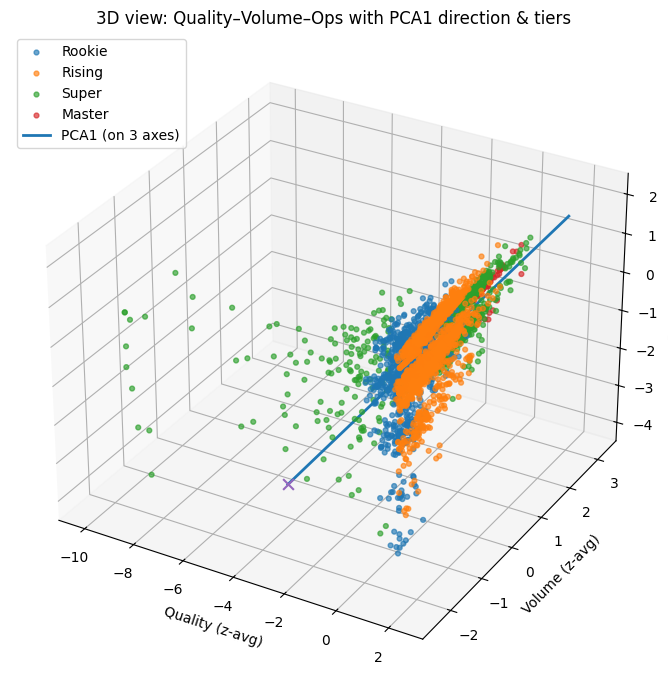

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from sklearn.decomposition import PCA as _PCA

def _zscore(df_sub: pd.DataFrame) -> pd.DataFrame:
    mu = df_sub.mean(axis=0)
    sd = df_sub.std(axis=0).replace(0, np.nan)
    return (df_sub - mu) / sd

def _safe_cols(df, cols): return [c for c in (cols or []) if c in df.columns]

assert 'df' in globals(), "df가 필요합니다(호스트 단위 집계 DataFrame)."
assert 'out' in globals() and 'tier_gmm' in out.columns, "out['tier_gmm']가 필요합니다."
src = X if 'X' in globals() and isinstance(X, pd.DataFrame) else df

quality_cols = _safe_cols(src, globals().get('quality_feats', []))
volume_cols  = _safe_cols(src, globals().get('volume_feats',  []))
ops_cols     = _safe_cols(src, globals().get('ops_feats',     []))
assert (quality_cols or volume_cols or ops_cols), "quality/volume/ops 컬럼이 필요합니다."

axes = {}
if quality_cols: axes['Quality'] = _zscore(src[quality_cols]).mean(axis=1)
if volume_cols:  axes['Volume']  = _zscore(src[volume_cols]).mean(axis=1)
if ops_cols:     axes['Ops']     = _zscore(src[ops_cols]).mean(axis=1)
axes_df = pd.DataFrame(axes, index=src.index)

plot_df = axes_df.join(out[['tier_gmm']], how='inner').dropna(subset=['Quality','Volume','Ops'])

pca3 = _PCA(n_components=1, random_state=42).fit(plot_df[['Quality','Volume','Ops']].values)
v = pca3.components_[0] / np.linalg.norm(pca3.components_[0])
L = 4.0
line_pts = np.vstack([-L*v, L*v])

cuts_arr = np.asarray(globals().get('cuts', []))
cut_marks = None
if cuts_arr.size == 3:
    cabs = np.max(np.abs(cuts_arr)) or 1.0
    tvals = (cuts_arr / cabs) * L
    cut_marks = (v.reshape(1,-1) * tvals.reshape(-1,1))

# ---- 3D Scatter ----
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Quality (z-avg)")
ax.set_ylabel("Volume (z-avg)")
ax.set_zlabel("Ops (z-avg)")
ax.set_title("3D view: Quality–Volume–Ops with PCA1 direction & tiers")

for t in ["Rookie","Rising","Super","Master"]:
    m = (plot_df["tier_gmm"]==t)
    if m.any():
        ax.scatter(plot_df.loc[m,"Quality"],
                   plot_df.loc[m,"Volume"],
                   plot_df.loc[m,"Ops"],
                   s=12, alpha=0.65, label=t)


ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2], linewidth=2, label="PCA1 (on 3 axes)")

if cut_marks is not None:
    for p in cut_marks:
        ax.scatter(p[0], p[1], p[2], s=60, marker='x')

ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


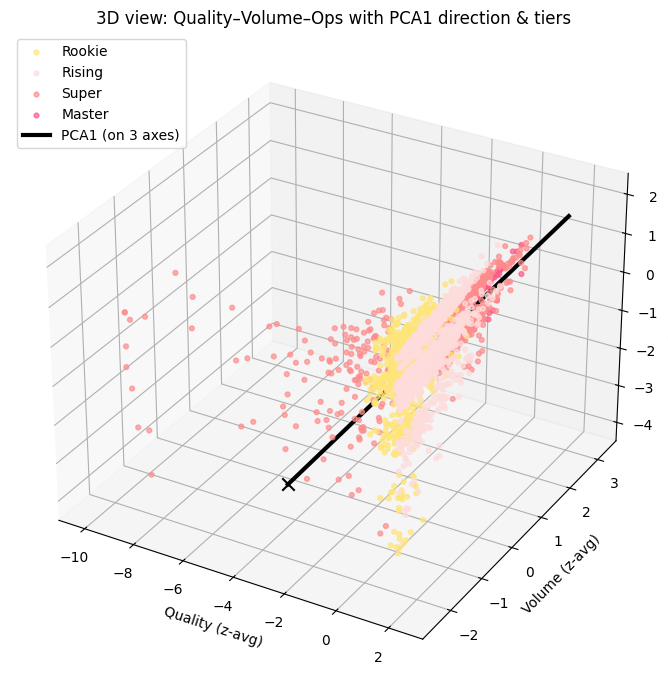

In [ ]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Quality (z-avg)")
ax.set_ylabel("Volume (z-avg)")
ax.set_zlabel("Ops (z-avg)")
ax.set_title("3D view: Quality–Volume–Ops with PCA1 direction & tiers")


tier_colors = {
    "Rookie": "#Ffe57a",
    "Rising": "#Fedcdc",
    "Super":  "#fe8c8c",
    "Master": "#ff5987"
}

for t in ["Rookie","Rising","Super","Master"]:
    m = (plot_df["tier_gmm"]==t)
    if m.any():
        ax.scatter(plot_df.loc[m,"Quality"],
                   plot_df.loc[m,"Volume"],
                   plot_df.loc[m,"Ops"],
                   s=12, alpha=0.7, label=t, color=tier_colors[t])

ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2],
        linewidth=3, color="black", label="PCA1 (on 3 axes)")

if cut_marks is not None:
    for p in cut_marks:
        ax.scatter(p[0], p[1], p[2], s=80, marker='x', color="black")

ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

[Spearman] ρ = 0.757, p = 0.00e+00


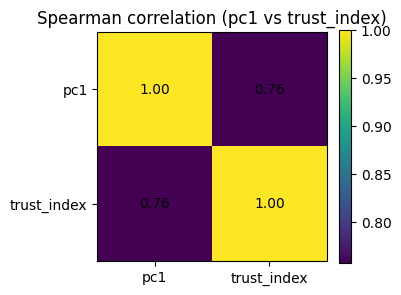

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


mask = np.isfinite(pc1) & np.isfinite(ti_aligned)
x = pc1[mask]
y = ti_aligned[mask]

rho, p = spearmanr(x, y, nan_policy="omit")
print(f"[Spearman] ρ = {rho:.3f}, p = {p:.2e}")

M = np.array([[1.0, rho],
              [rho, 1.0]])

fig = plt.figure(figsize=(4, 3.5))
ax = fig.add_subplot(111)
im = ax.imshow(M, aspect='equal')
plt.colorbar(im, ax=ax, fraction=0.046)

ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["pc1", "trust_index"])
ax.set_yticklabels(["pc1", "trust_index"])

for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{M[i,j]:.2f}", ha="center", va="center")

ax.set_title("Spearman correlation (pc1 vs trust_index)")
plt.tight_layout()
plt.show()